In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd

### NACA 4 digit airfoil generator

In [10]:
def naca_airfoil(code, num_points, zero_thick_te=False, uniform=False):
    """Return a NACA 4-digit series airfoil"""
    # extract parameters from 4-digit code
    code_str = "%04d" % int(code)
    if len(code_str) != 4:
        raise ValueError("NACA designation is more than 4 digits")
    max_camber = 0.01 * int(code_str[0])
    p = 0.1 * int(code_str[1])  # location of max camber
    thickness = 0.01 * int(code_str[2:])
    if uniform:
        x = np.linspace(0, 1, num_points)
    else:
        # closer spacing near leading edge
        theta = np.linspace(0, 0.5 * np.pi, num_points)
        x = 1 - np.cos(theta)

    # thickness
    coefs = [-0.1015, 0.2843, -0.3516, -0.1260, 0, 0.2969]
    if zero_thick_te:
        coefs[0] = -0.1036
    y_thick = 5 * thickness * (np.polyval(coefs[:5], x) +
                               coefs[5] * np.sqrt(x))

    # camber
    front = np.where(x <= p)
    back = np.where(x > p)
    y_camber = np.zeros_like(x)
    if p:
        y_camber[front] = max_camber * x[front] / p**2 * (2 * p - x[front])
        y_camber[back] = max_camber * ((1. - x[back])/(1. - p)**2 *
                                       (1 + x[back] - 2 * p))
    x = np.hstack([x[-1:0:-1], x])
    y = np.hstack([y_camber[-1:0:-1] + y_thick[-1:0:-1],
                   y_camber - y_thick])
    return (np.array([x, y]).T)

### Declaring a variable to store cooridnates of airfoil

In [11]:
q = naca_airfoil(0012, 101)

### Collacation point (obervations point on the airfoil where the vortex influence will be captured)

In [12]:
q_mid = (q[1:] + q[:-1])/2

### Defining the computational domain where the vortices are distributed

In [13]:
length = 10. #nondimensional length of window
height = 0.2 #window height
v0 = 5 #convection speed
N = 10000 #number of vortices
gammas = 1. #vortex strength RMS (normal distribution)
rscale = 0.1 #vortex size scale (rayleigh distribution parameter)
t0 = -(length / v0 / 2)  #start time for observation of convection
t1 = (length / v0 / 2)   #end time
ts = 0.01 # time step

### Set random distribution for vortex location, size and strength
origin at window center

In [14]:
vortx = np.random.uniform(low=-length/2,high=length/2,size=N)
vorty = np.random.uniform(low=-height/2,high=height/2,size=N)
vortX = np.vstack((vortx,vorty))
gamma = np.random.normal(scale=gammas,size=N)
rho = np.random.rayleigh(scale=rscale,size=N)

### Solver/time-stepper

In [15]:
t = np.arange(t0,t1,ts) # number of time-steps
print t
print len(t)

[-1.0000000e+00 -9.9000000e-01 -9.8000000e-01 -9.7000000e-01
 -9.6000000e-01 -9.5000000e-01 -9.4000000e-01 -9.3000000e-01
 -9.2000000e-01 -9.1000000e-01 -9.0000000e-01 -8.9000000e-01
 -8.8000000e-01 -8.7000000e-01 -8.6000000e-01 -8.5000000e-01
 -8.4000000e-01 -8.3000000e-01 -8.2000000e-01 -8.1000000e-01
 -8.0000000e-01 -7.9000000e-01 -7.8000000e-01 -7.7000000e-01
 -7.6000000e-01 -7.5000000e-01 -7.4000000e-01 -7.3000000e-01
 -7.2000000e-01 -7.1000000e-01 -7.0000000e-01 -6.9000000e-01
 -6.8000000e-01 -6.7000000e-01 -6.6000000e-01 -6.5000000e-01
 -6.4000000e-01 -6.3000000e-01 -6.2000000e-01 -6.1000000e-01
 -6.0000000e-01 -5.9000000e-01 -5.8000000e-01 -5.7000000e-01
 -5.6000000e-01 -5.5000000e-01 -5.4000000e-01 -5.3000000e-01
 -5.2000000e-01 -5.1000000e-01 -5.0000000e-01 -4.9000000e-01
 -4.8000000e-01 -4.7000000e-01 -4.6000000e-01 -4.5000000e-01
 -4.4000000e-01 -4.3000000e-01 -4.2000000e-01 -4.1000000e-01
 -4.0000000e-01 -3.9000000e-01 -3.8000000e-01 -3.7000000e-01
 -3.6000000e-01 -3.50000

In [16]:
A = [] # empty array to store cl value after each iteration
for i in range(len(t)):
    print "this is the iteration {} / {}".format(i, len(t))
    i = i * ts * v0
    obsx = q_mid[:,0] + (length/2)
    obsx = (obsx - i )
    obsy = q_mid[:,1]
    obsX = np.vstack((obsx,obsy))
    dist = obsX[:,:,np.newaxis]-vortX[:,np.newaxis,:] # dim 2 x timesteps x N
    r = np.sqrt((dist*dist).sum(0)) # dim timesteps x N
    utheta = 16 * gamma * (rho**(-3)) * np.exp(-8*(rho**(-4)) * r**2) * (3-(16 * (rho**(-4)) * r**2)) * r   # Mexican-hat shape
    uind = utheta * dist[::-1] # dim 2 x timesteps x N
    uind[0] *= -1 # change sign for ux (to get correct rotation)
    utot = uind.sum(2) # dim 2 x timesteps
    q_newx = q[:,0] + (length/2)
    q_newx = q_newx - i
    q_newy = q[:,1]
    q = np.array([q_newx, q_newy]).T
    dq = np.diff(q, axis=0)
    numpanels = dq.shape[0]
    lengths = np.linalg.norm(dq, axis=1) 
    normals = np.transpose(np.array([dq[:,1], -dq[:,0]]) / lengths)
    tangents = -np.transpose(np.array([dq[:,0], dq[:,1]]) / lengths)
    utot_tangent = utot.T * tangents
    utot_tangent_magnitude = pow((pow(utot_tangent[:,0],2) + pow(utot_tangent[:,1],2)), 0.5)
    cp = (1 - ((utot_tangent_magnitude**2)/v0**2))
    cp = cp * normals[:,1]
    cl = cp.sum(0)
    A.append(cl)

this is the iteration 0 / 200
this is the iteration 1 / 200
this is the iteration 2 / 200
this is the iteration 3 / 200
this is the iteration 4 / 200
this is the iteration 5 / 200
this is the iteration 6 / 200
this is the iteration 7 / 200
this is the iteration 8 / 200
this is the iteration 9 / 200
this is the iteration 10 / 200
this is the iteration 11 / 200
this is the iteration 12 / 200
this is the iteration 13 / 200
this is the iteration 14 / 200
this is the iteration 15 / 200
this is the iteration 16 / 200
this is the iteration 17 / 200
this is the iteration 18 / 200
this is the iteration 19 / 200
this is the iteration 20 / 200
this is the iteration 21 / 200
this is the iteration 22 / 200
this is the iteration 23 / 200
this is the iteration 24 / 200
this is the iteration 25 / 200
this is the iteration 26 / 200
this is the iteration 27 / 200
this is the iteration 28 / 200
this is the iteration 29 / 200
this is the iteration 30 / 200
this is the iteration 31 / 200
this is the iterat

#### Unsteady lift

In [17]:
A = np.array(A)

### Curle's analogy to obtain p' at a distance of 1 unit at theta=90 deg

In [18]:
def Curles_loadingNoise(y_int,c_sound,r_dist,L,dt,Velo):
    p_acoustic = (((y_int*L)/(4*np.pi*dt*c_sound*(r_dist**2)))*(0.5*1.225*pow(Velo,2)))
    return p_acoustic

noise = Curles_loadingNoise(1,343,1,np.abs(A),ts,v0)
H = ((noise)/(2.e-5))**2

### Plot unsteady lift on the airfoil and the SPL in far-field 

<function matplotlib.pyplot.show>

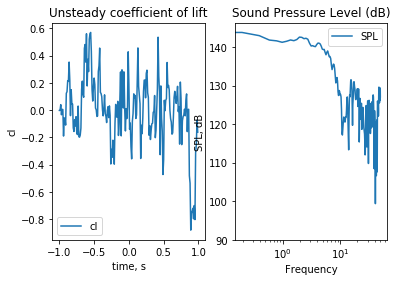

In [19]:
plt.figure(1)
plt.subplot(1,2,1)
plt.plot(t,A,label='cl')
plt.title('Unsteady coefficient of lift')
plt.xlabel('time, s')
plt.ylabel('cl')
plt.legend()
plt.subplot(1,2,2)
(val, freq) = psd(H, NFFT=512,Fs=1/ts,detrend='mean')
plt.semilogx(freq,10*np.log10(val),label='SPL')
plt.title('Sound Pressure Level (dB)')
plt.xlabel('Frequency')
plt.ylabel('SPL, dB')
plt.legend()
plt.savefig('cl_SPL.pdf')
plt.show